# Classifier-Free Guidance (CFG) Implementation

This notebook implements Classifier-Free Guidance for diffusion models. CFG allows for better control over the generation process by:

1. Training the model to handle both conditional (with labels) and unconditional (without labels) generation
2. During sampling, combining conditional and unconditional predictions using a guidance scale
3. The guidance scale controls how strongly the model follows the conditioning

Key components:
- **Unconditional training**: Randomly drop labels during training (set to None)
- **CFG sampling**: Combine conditional and unconditional predictions
- **Guidance scale**: Higher values = stronger conditioning, lower values = more diversity

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
device = torch.device("xpu")

In [3]:
def _sinusodial_pos_encoding(t, output_dim: int, device: torch.device | str = "cpu"):
    v = torch.zeros(output_dim, device=device)

    i = torch.arange(0, output_dim, device=device)
    div_term = 10000 ** (i / output_dim)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])

    return v


def sinusodal_pos_encoding(t, output_dim: int, device: torch.device | str = "cpu"):
    batch_size = len(t)
    v = torch.zeros(batch_size, output_dim, device=device)

    for i in range(batch_size):
        v[i] = _sinusodial_pos_encoding(t[i], output_dim, device)

    return v


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_dim: int):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(time_dim, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, in_channels),
        )

    def forward(self, x: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        N, C, _, _ = x.shape
        v = self.mlp(v).view(N, C, 1, 1)
        y = self.conv(x + v)
        return y


class UNet(nn.Module):
    def __init__(self, in_channels: int = 1, time_dim: int = 100, num_labels=None):
        super().__init__()

        self.time_dim = time_dim
        self.num_labels = num_labels

        self.down1 = ConvBlock(in_channels, 64, time_dim)
        self.down2 = ConvBlock(64, 128, time_dim)
        self.bot1 = ConvBlock(128, 256, time_dim)
        self.up2 = ConvBlock(256 + 128, 128, time_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_dim)
        self.out = nn.Conv2d(64, in_channels, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")

        if num_labels is not None:
            self.label_embedding = nn.Embedding(num_labels, time_dim)
            # Add a special embedding for unconditional generation (class index = num_labels)
            self.unconditional_embedding = nn.Parameter(torch.randn(time_dim))

    def forward(self, x: torch.Tensor, time_steps, labels=None) -> torch.Tensor:
        t = sinusodal_pos_encoding(time_steps, self.time_dim, device=x.device)

        if self.num_labels is not None:
            if labels is not None:
                # Conditional generation
                t = t + self.label_embedding(labels)
            else:
                # Unconditional generation - use special unconditional embedding
                batch_size = x.shape[0]
                unconditional_emb = self.unconditional_embedding.unsqueeze(0).expand(
                    batch_size, -1
                )
                t = t + unconditional_emb

        x1 = self.down1(x, t)
        x = self.maxpool(x1)

        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)

        return x

In [4]:
class Diffuser:
    def __init__(
        self,
        num_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        device: torch.device | str = "cpu",
    ):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.bar_alphas = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0: torch.Tensor, t: torch.Tensor):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_index = t - 1
        bar_alpha = self.bar_alphas[t_index]
        N = bar_alpha.size(0)
        bar_alpha = bar_alpha.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(bar_alpha) * x_0 + torch.sqrt(1 - bar_alpha) * noise

        return x_t, noise

    def denoise(
        self,
        model: torch.nn.Module,
        x: torch.Tensor,
        t: torch.Tensor,
        labels=None,
        guidance_scale=1.0,
    ):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_index = t - 1
        alpha = self.alphas[t_index]
        bar_alpha = self.bar_alphas[t_index]
        bar_alpha_prev = self.bar_alphas[t_index - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        bar_alpha = bar_alpha.view(N, 1, 1, 1)
        bar_alpha_prev = bar_alpha_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            if labels is not None and guidance_scale > 1.0:
                # Classifier-Free Guidance
                # Get conditional prediction
                eps_cond = model(x, t, labels)
                # Get unconditional prediction (no labels)
                eps_uncond = model(x, t, None)
                # Combine predictions using guidance scale
                eps = eps_uncond + guidance_scale * (eps_cond - eps_uncond)
            else:
                # Standard prediction
                eps = model(x, t, labels)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - bar_alpha)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - bar_alpha_prev) / (1 - bar_alpha))

        return mu + std * noise

    def reverse(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        return transforms.ToPILImage()(x)

    def sample(
        self,
        model: torch.nn.Module,
        x_shape=(20, 1, 28, 28),
        labels=None,
        guidance_scale=1.0,
    ):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        if labels is not None:
            if isinstance(labels, int):
                # Generate random labels if just num_labels is provided
                labels = torch.randint(0, labels, (batch_size,), device=self.device)
            elif isinstance(labels, (list, tuple)):
                # Convert to tensor if list/tuple provided
                labels = torch.tensor(labels, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.int64)
            x = self.denoise(model, x, t, labels, guidance_scale)

        images = [self.reverse(x[i]) for i in range(batch_size)]

        return images, labels

Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:40<00:00, 24.78it/s]



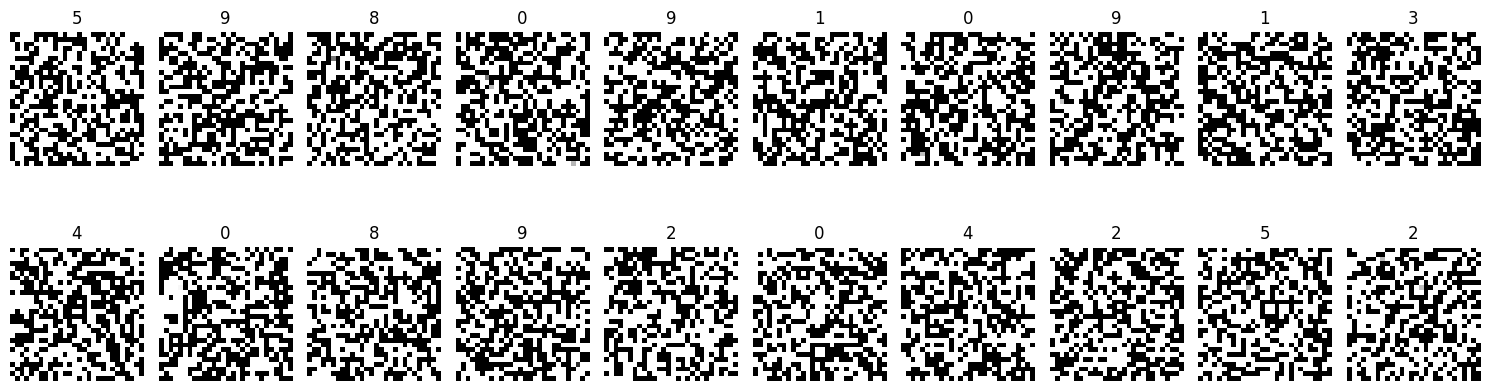

100%|██████████| 469/469 [02:01<00:00,  3.86it/s]


Epoch 1/10, Loss: 0.0536
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:39<00:00, 25.41it/s]



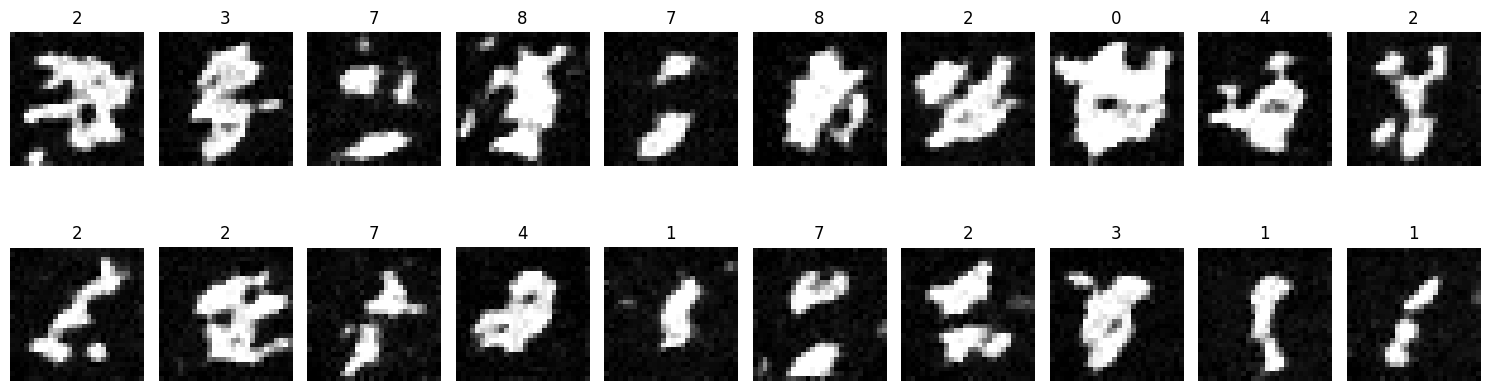

100%|██████████| 469/469 [02:00<00:00,  3.90it/s]


Epoch 2/10, Loss: 0.0289
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:40<00:00, 24.69it/s]



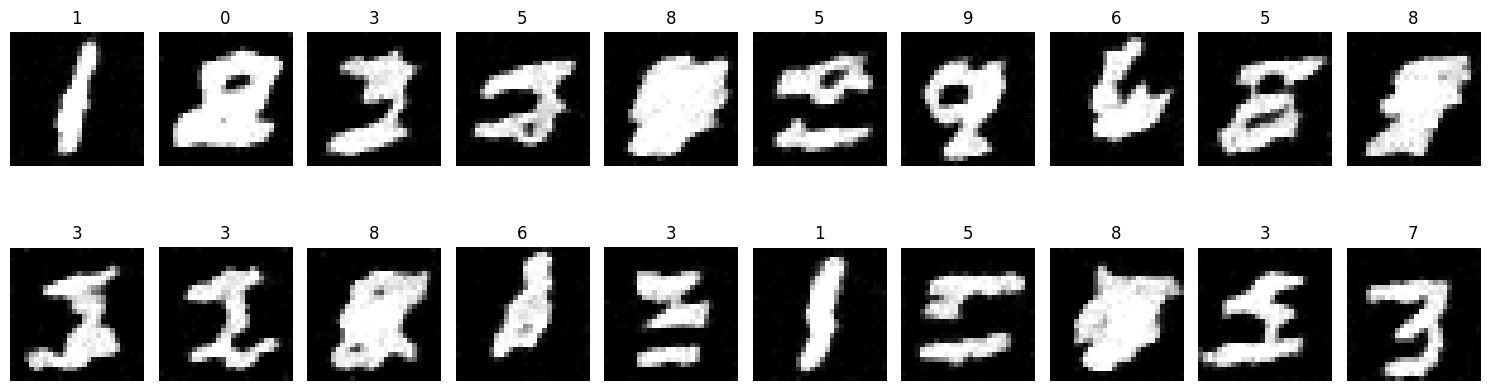

100%|██████████| 469/469 [02:04<00:00,  3.76it/s]


Epoch 3/10, Loss: 0.0254
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:42<00:00, 23.69it/s]



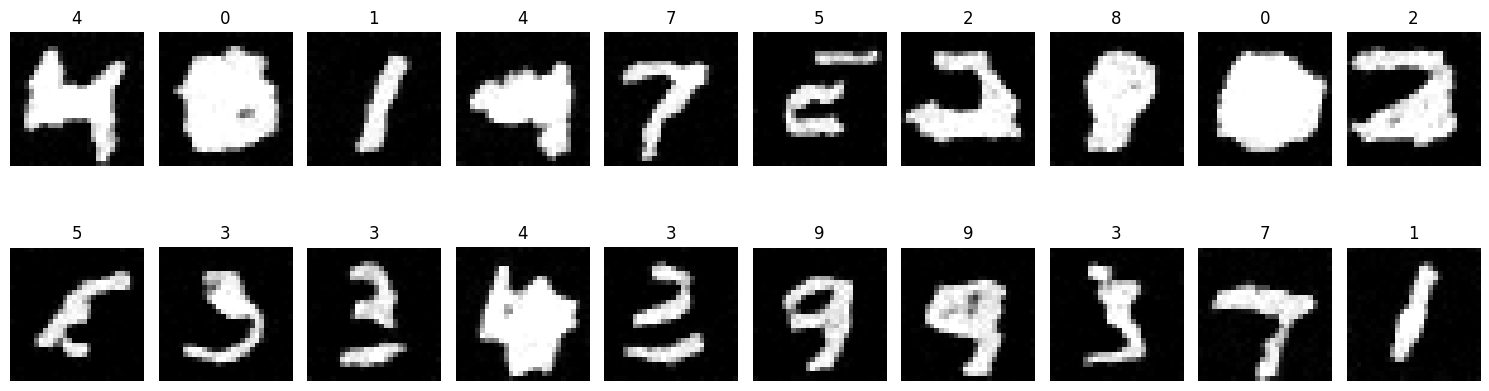

100%|██████████| 469/469 [02:05<00:00,  3.75it/s]


Epoch 4/10, Loss: 0.0230
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:42<00:00, 23.46it/s]



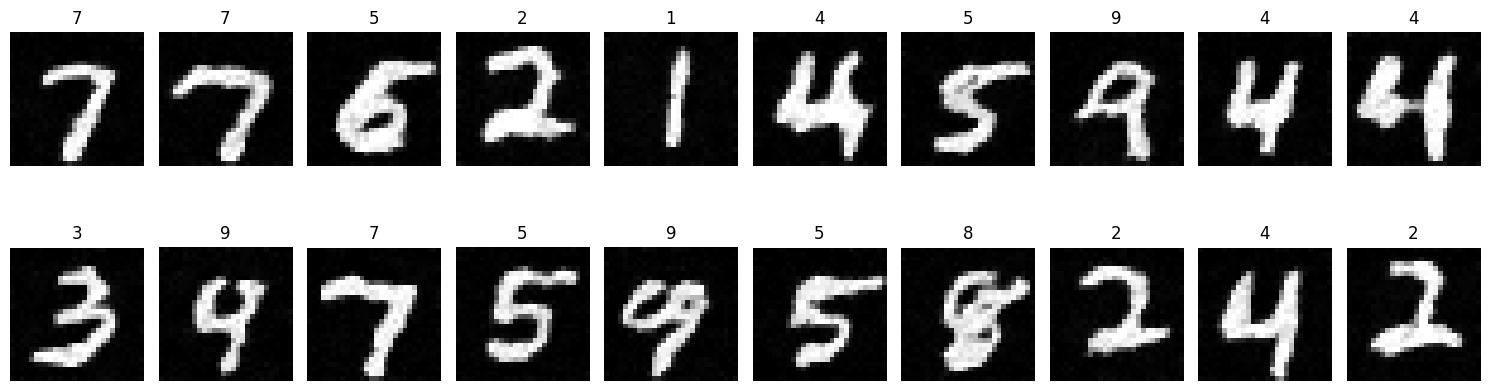

100%|██████████| 469/469 [02:05<00:00,  3.73it/s]


Epoch 5/10, Loss: 0.0215
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:43<00:00, 22.94it/s]



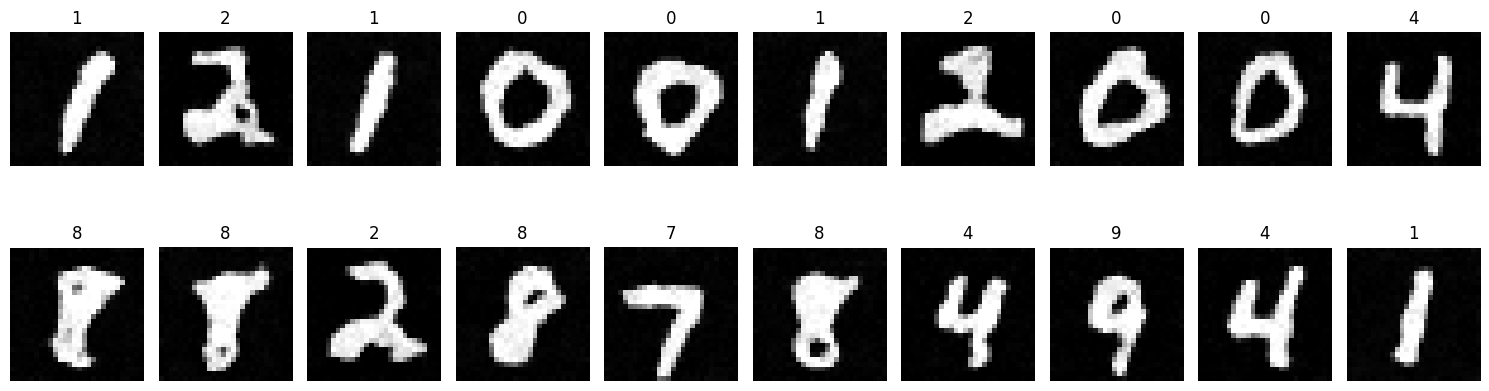

100%|██████████| 469/469 [02:20<00:00,  3.33it/s]


Epoch 6/10, Loss: 0.0244
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]



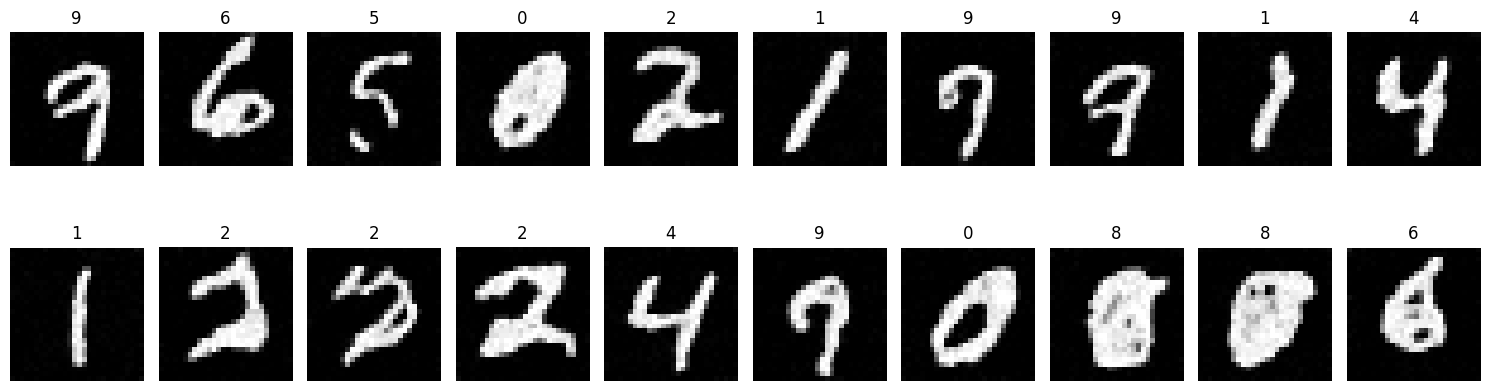

100%|██████████| 469/469 [02:04<00:00,  3.76it/s]


Epoch 7/10, Loss: 0.0205
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:42<00:00, 23.29it/s]



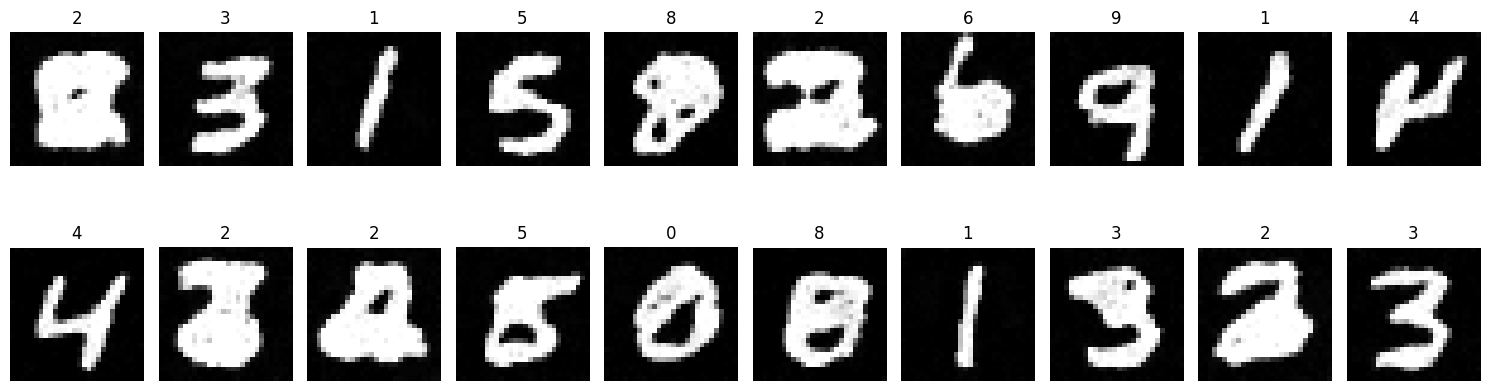

100%|██████████| 469/469 [02:06<00:00,  3.70it/s]


Epoch 8/10, Loss: 0.0198
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:42<00:00, 23.77it/s]



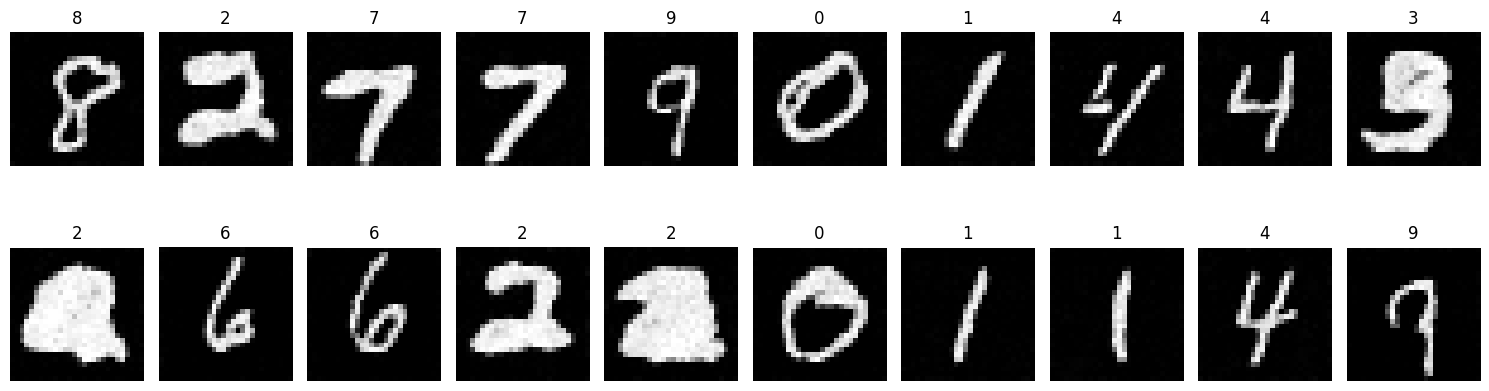

100%|██████████| 469/469 [02:11<00:00,  3.55it/s]


Epoch 9/10, Loss: 0.0188
Sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:46<00:00, 21.49it/s]



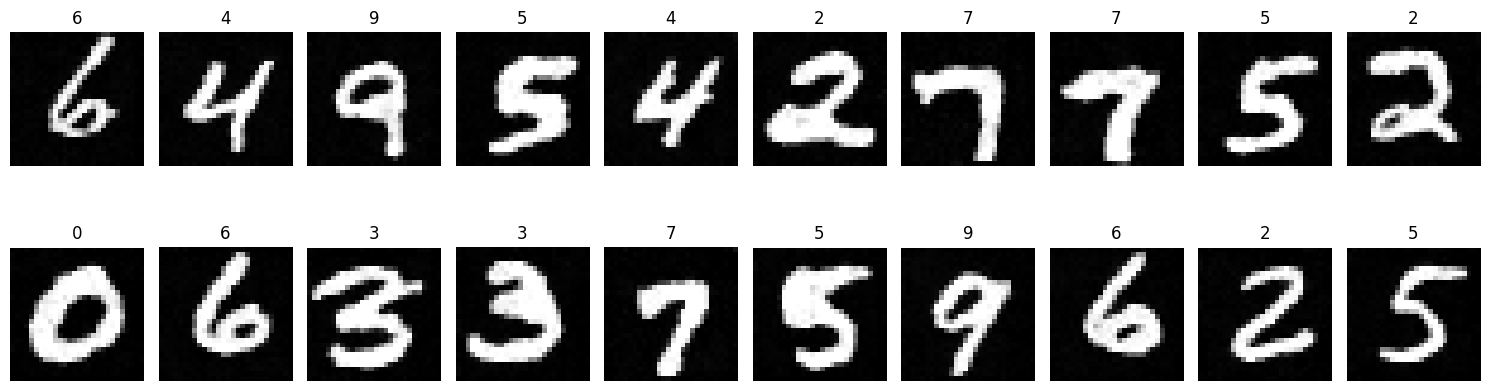

100%|██████████| 469/469 [02:22<00:00,  3.30it/s]



Epoch 10/10, Loss: 0.0187


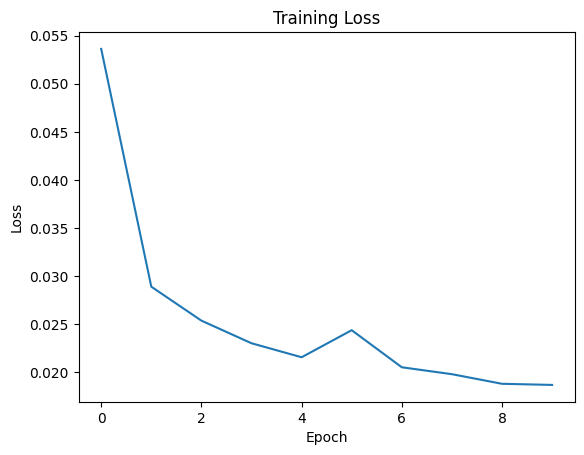

Final sampling with guidance scale 3.0...


100%|██████████| 1000/1000 [00:40<00:00, 24.67it/s]



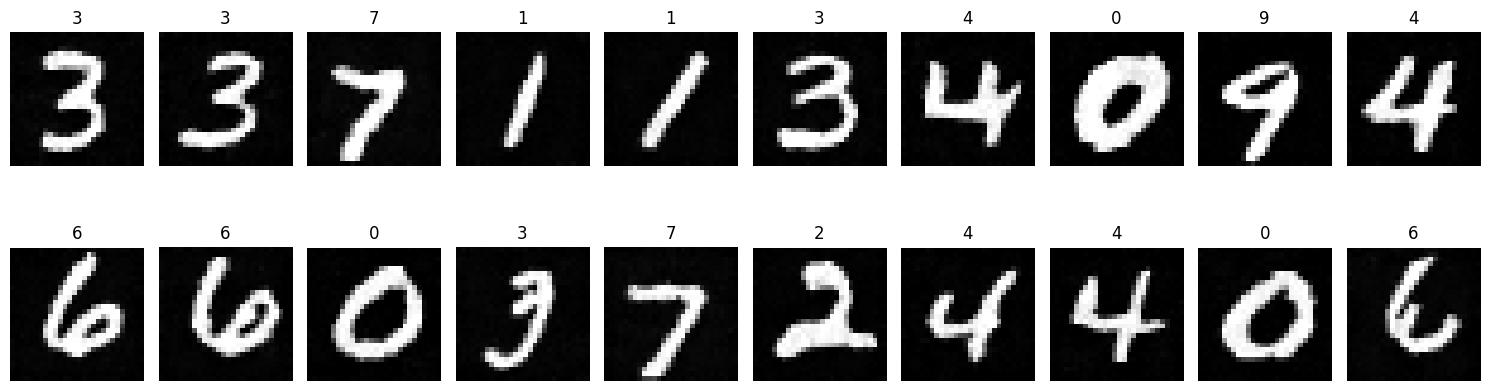

In [5]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
num_labels = 10
# CFG parameters
cfg_dropout_prob = 0.1  # Probability of dropping labels for unconditional training
guidance_scale = 3.0  # Guidance scale for sampling


def show_images(images, labels, rows=2, cols=10):
    fig = plt.figure(figsize=(15, 5))
    for row in range(rows):
        for col in range(cols):
            idx = row * cols + col
            if idx < len(images):
                ax = fig.add_subplot(rows, cols, idx + 1)
                ax.imshow(images[idx], cmap="gray")
                ax.axis("off")
                if labels is not None:
                    ax.set_title(f"{labels[idx].item()}")
    plt.tight_layout()
    plt.show()


transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST("./data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size, True)

diffuser = Diffuser(
    num_timesteps=num_timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    device=device,
)
model = UNet(num_labels=num_labels)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr)

losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    count = 0

    # Sample with CFG
    print(f"Sampling with guidance scale {guidance_scale}...")
    images, labels = diffuser.sample(
        model, labels=num_labels, guidance_scale=guidance_scale
    )
    show_images(images, labels)

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)

        # Classifier-Free Guidance training: randomly drop labels
        if np.random.random() < cfg_dropout_prob:
            # Unconditional training - set labels to None
            train_labels = None
        else:
            # Conditional training - use actual labels
            train_labels = labels

        t = torch.randint(
            1, num_timesteps + 1, (len(x),), device=device, dtype=torch.int64
        )

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, train_labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        count += 1

    loss_avg = loss_sum / count
    losses.append(loss_avg)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_avg:.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Final sampling with CFG
print(f"Final sampling with guidance scale {guidance_scale}...")
images, labels = diffuser.sample(
    model, labels=num_labels, guidance_scale=guidance_scale
)
show_images(images, labels)

In [6]:
from safetensors.torch import save_file

save_file(
    model.state_dict(),
    "models/cfg_diffuser_unet.safetensors",
    metadata={"format": "torch"},
)
print("Model weights saved to models/cfg_diffuser_unet.safetensors")

Model weights saved to models/cfg_diffuser_unet.safetensors


Comparing different guidance scales:
Generating with guidance scale 1.0...


100%|██████████| 1000/1000 [00:09<00:00, 110.64it/s]


Generating with guidance scale 2.0...


100%|██████████| 1000/1000 [00:13<00:00, 73.22it/s]



Generating with guidance scale 3.0...


100%|██████████| 1000/1000 [00:13<00:00, 71.53it/s]


Generating with guidance scale 5.0...


100%|██████████| 1000/1000 [00:13<00:00, 75.07it/s]


Generating with guidance scale 7.0...


100%|██████████| 1000/1000 [00:14<00:00, 69.06it/s]



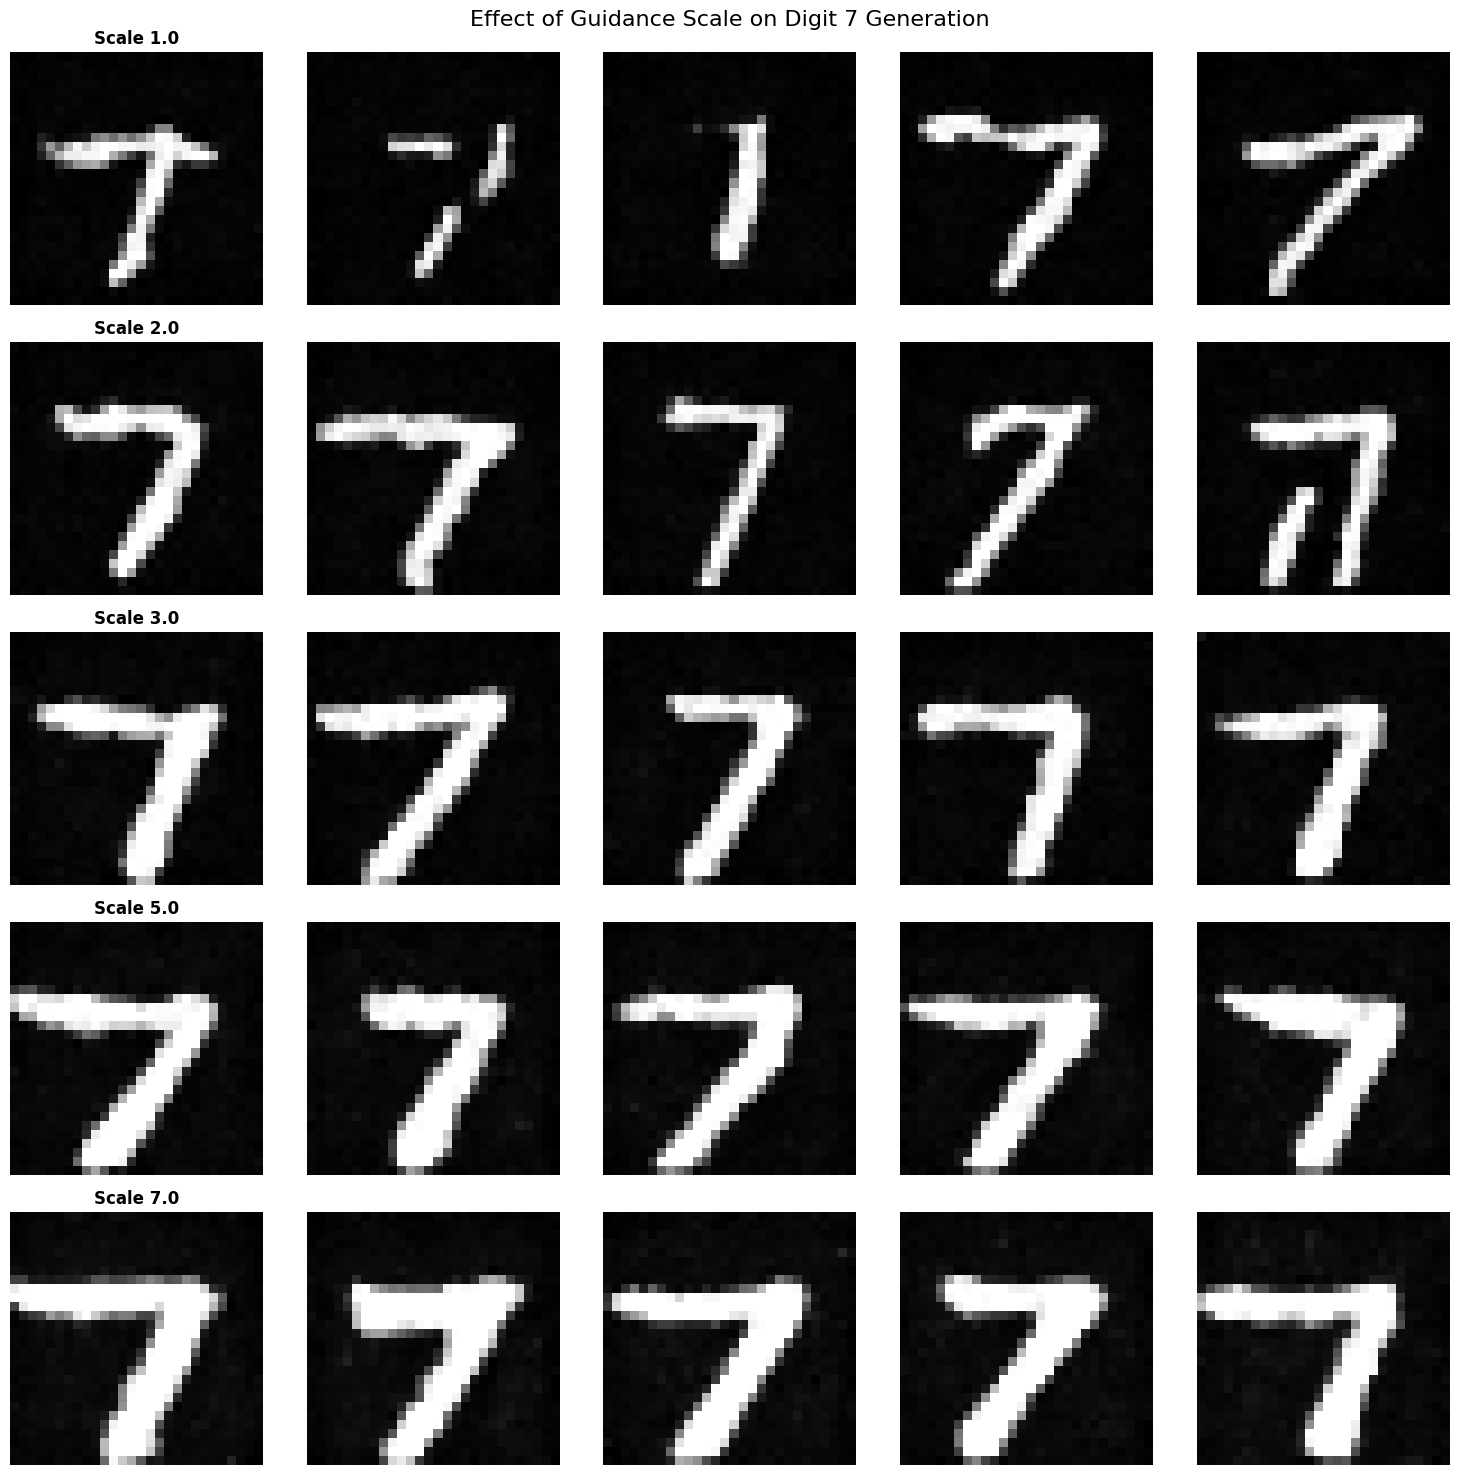


Guidance Scale Effects:
- Scale 1.0: No guidance (standard conditional generation)
- Scale 2.0-3.0: Moderate guidance (good balance)
- Scale 5.0+: Strong guidance (higher fidelity but less diversity)


In [7]:
# Demonstrate the effect of different guidance scales
print("Comparing different guidance scales:")

guidance_scales = [1.0, 2.0, 3.0, 5.0, 7.0]
target_digit = 7  # Generate images of digit 7

fig, axes = plt.subplots(
    len(guidance_scales), 5, figsize=(15, 3 * len(guidance_scales))
)

for i, scale in enumerate(guidance_scales):
    print(f"Generating with guidance scale {scale}...")

    # Generate 5 images of the target digit
    target_labels = [target_digit] * 5
    images, _ = diffuser.sample(
        model, x_shape=(5, 1, 28, 28), labels=target_labels, guidance_scale=scale
    )

    for j, img in enumerate(images):
        axes[i, j].imshow(img, cmap="gray")
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(f"Scale {scale}", fontsize=12, fontweight="bold")

plt.suptitle(
    f"Effect of Guidance Scale on Digit {target_digit} Generation", fontsize=16
)
plt.tight_layout()
plt.show()

print("\nGuidance Scale Effects:")
print("- Scale 1.0: No guidance (standard conditional generation)")
print("- Scale 2.0-3.0: Moderate guidance (good balance)")
print("- Scale 5.0+: Strong guidance (higher fidelity but less diversity)")

Comparing conditional vs unconditional generation:
Generating unconditional samples...


100%|██████████| 1000/1000 [00:12<00:00, 78.10it/s]


Generating conditional samples (no CFG)...


100%|██████████| 1000/1000 [00:13<00:00, 73.77it/s]


Generating conditional samples (with CFG)...


100%|██████████| 1000/1000 [00:21<00:00, 46.34it/s]



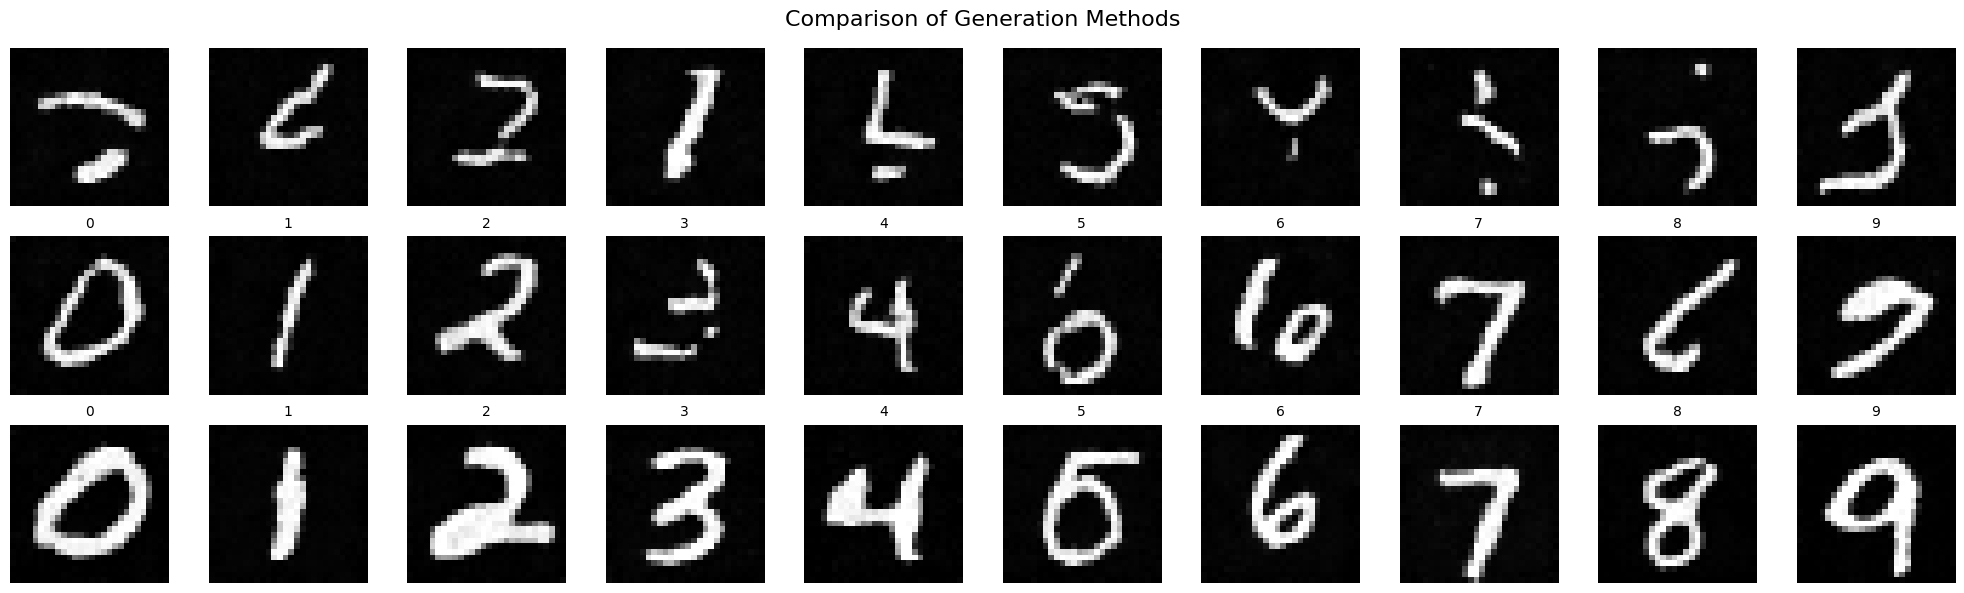


Comparison:
- Top row: Unconditional - random digits, diverse but less controlled
- Middle row: Conditional without CFG - follows labels but may be less sharp
- Bottom row: Conditional with CFG - follows labels with better quality and clarity


In [8]:
# Compare conditional vs unconditional generation
print("Comparing conditional vs unconditional generation:")

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

# Unconditional generation (no labels)
print("Generating unconditional samples...")
uncond_images, _ = diffuser.sample(model, x_shape=(10, 1, 28, 28), labels=None)
for i, img in enumerate(uncond_images):
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Unconditional", fontsize=12, fontweight="bold")

# Conditional generation without CFG (guidance_scale=1.0)
print("Generating conditional samples (no CFG)...")
cond_labels = list(range(10))  # One of each digit
cond_images_no_cfg, _ = diffuser.sample(
    model, x_shape=(10, 1, 28, 28), labels=cond_labels, guidance_scale=1.0
)
for i, img in enumerate(cond_images_no_cfg):
    axes[1, i].imshow(img, cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"{cond_labels[i]}", fontsize=10)
    if i == 0:
        axes[1, i].set_ylabel("Conditional\n(no CFG)", fontsize=12, fontweight="bold")

# Conditional generation with CFG (guidance_scale=3.0)
print("Generating conditional samples (with CFG)...")
cond_images_cfg, _ = diffuser.sample(
    model, x_shape=(10, 1, 28, 28), labels=cond_labels, guidance_scale=3.0
)
for i, img in enumerate(cond_images_cfg):
    axes[2, i].imshow(img, cmap="gray")
    axes[2, i].axis("off")
    axes[2, i].set_title(f"{cond_labels[i]}", fontsize=10)
    if i == 0:
        axes[2, i].set_ylabel("Conditional\n(with CFG)", fontsize=12, fontweight="bold")

plt.suptitle("Comparison of Generation Methods", fontsize=16)
plt.tight_layout()
plt.show()

print("\nComparison:")
print("- Top row: Unconditional - random digits, diverse but less controlled")
print("- Middle row: Conditional without CFG - follows labels but may be less sharp")
print(
    "- Bottom row: Conditional with CFG - follows labels with better quality and clarity"
)